In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab
import pathlib
import os
import scipy
from scipy.interpolate import *
from tqdm import tqdm

In [2]:
datapath= pathlib.WindowsPath("C:/Users/randi/Desktop/Master's Archive/")
os.chdir(datapath)

# Ingesting file

In [3]:
filepath = './single track/single track.dat'

## Getting times and locations of arrays

In [4]:
with open(filepath,'r') as file:
    i=0
    start = 0
    end = -1
    time = []
    dflist = []
    tloc = []
    for num,line in enumerate(file):
        pos = line.find('t=')
        
        if pos==-1:
            i+=1
        else:
            time.append(float(line[pos+2:].split(' ')[0]))
            tloc.append(num)
tloc = np.array(tloc)
time = np.array(time)

In [5]:
startloc = tloc+2
endloc = tloc[1:] - 3
endloc = np.append(endloc,num)

In [6]:
print(time,len(time))


[0.         0.05000152 0.09999861 0.14999799 0.200002   0.24999768
 0.29999819 0.35000142 0.39999574 0.45000035 0.49999568 0.54999572
 0.59999555 0.64999849 0.69999963 0.75000352 0.80000329 0.84999901
 0.89999628 0.95000225 1.0000044  1.0499988  1.100001   1.1500036
 1.1999959  1.2499999  1.300004   1.350003   1.4000012  1.4499985
 1.4999993  1.550001   1.6000009  1.6500031  1.6999987  1.7499976
 1.7999986  1.8499968  1.9000001  1.9499962  1.9999994  2.0500035
 2.1000037 ] 43


## Ingesting all the timestep information into a list

In [7]:
dflist = []
for i in tqdm(range(len(startloc))):
    df = pd.read_csv(filepath,delim_whitespace=True,skiprows=startloc[i],nrows = endloc[i]-startloc[i])
    dflist.append(df)

100%|██████████| 43/43 [40:08<00:00, 56.00s/it] 


## Making the mesh with the first timestep

In [8]:
df = dflist[0]

In [9]:
x = df.x.unique()
y = df.y.unique()
z = df.z.unique()

In [10]:
MeshX,MeshY,MeshZ = np.meshgrid(x,y,z,indexing='ij')

## Extracting all the fields to the mesh

In [11]:
fields = df.columns[3:]
fields

Index(['p', 'f', 'tn', 'fs'], dtype='object')

In [12]:
def extractField(field,dflist=dflist,shape=MeshX.shape):
    flist = []
    for df in dflist:
        flist.append(df[field].to_numpy().reshape(shape,order='F'))
    return np.array(flist)

In [13]:
# change directory to current script directory

os.chdir("G:\\My Drive\\Master's Project\\Data extractor\\Output Data")

In [14]:
fieldarr = []
for f in fields:
    fieldarr.append(extractField(f))
for field,arr in zip(fields,fieldarr):
    np.save(field,arr)
np.save('time',time)
np.save('MeshX',MeshX)
np.save('MeshY',MeshY)
np.save('MeshZ',MeshZ)

## Load data (if existing)

In [15]:
fields= [_[:-4] for _ in os.listdir() if '.npy' in _]
for _ in fields:
    exec(_ + " = np.load( '"+_+".npy')")

In [16]:
fields

['p', 'f', 'tn', 'scl2', 'fs', 'time', 'MeshX', 'MeshY', 'MeshZ']

In [6]:
MeshX.shape

(320, 107, 26)

# Process Data

## Visualizing data

In [7]:
tstep = 15
# # Vector
# a =  mlab.quiver3d(MeshX,MeshY,MeshZ,scl4[tstep],scl5[tstep],scl6[tstep])
# Scalar
a =  mlab.points3d(MeshX,MeshY,MeshZ,f[tstep])
mlab.show()

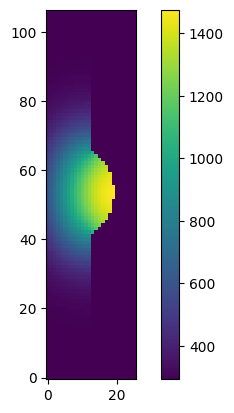

In [30]:
plt.imshow(tn[tstep,160,:,:],origin='lower')
plt.colorbar()

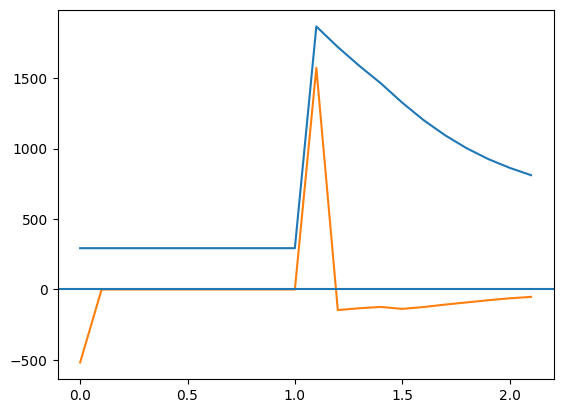

In [67]:
plt.plot(time,tn[:,160,50,13])
plt.plot(time,-np.roll(tn[:,160,50,13],1,axis=0)+tn[:,160,50,13])
plt.axhline(0)

## Extracting solidification times

In [27]:
tsol = 1693
tliq = 1733
tstep = 15

## Extracting Growth Velocity

$R = -\frac{\dot{T}}{T'}$

In [28]:
Tdot = np.gradient(tn,time,axis = 0)

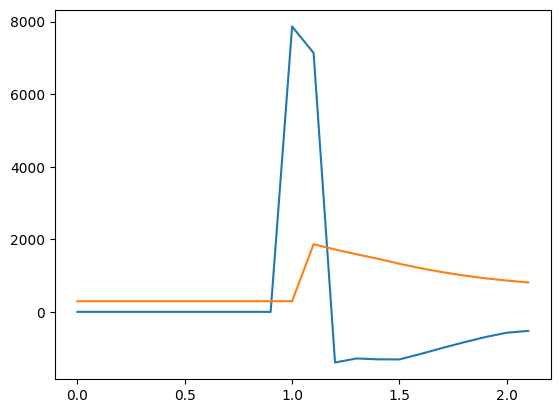

In [29]:
plt.plot(time,Tdot[:,160,50,13])
plt.plot(time,tn[:,160,50,13])

___Assuming constant X,Y and Z spacing...___

In [30]:
gradX = np.gradient(tn,MeshX[:,0,0],axis=1)
gradY = np.gradient(tn,MeshY[0,:,0],axis=2)
gradZ = np.gradient(tn,MeshZ[0,0,:],axis=3)
gradX[f==0] = 0
gradY[f==0] = 0
gradZ[f==0] = 0

In [31]:
grad = np.sqrt(gradX**2+gradY**2+gradZ**2)

In [32]:
R = np.zeros(tn.shape)
R[grad!=0] = -Tdot[grad!=0]/grad[grad!=0]

In [33]:
R[R<0] = 0      # Growth Velocity positive
R[tn>tliq] = 0  # No growth in liq
R[tn<tsol] = 0  # No growth in sol 
R[f==0] = 0     # No growth where no material present

In [26]:
np.max(tn)

2392.0403

## Postprocessing

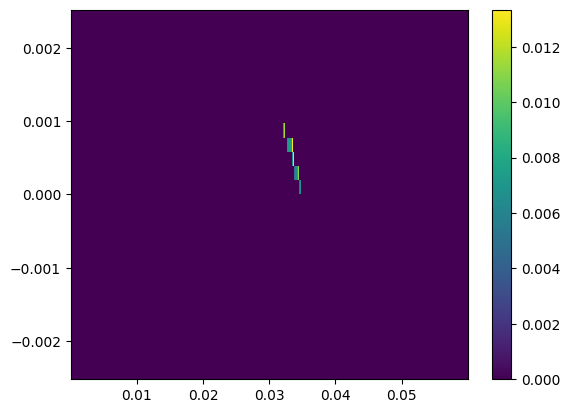

In [34]:
# plt.imshow(R[10,:,50,:].T)

plt.pcolormesh(MeshX[:,0,:],MeshZ[:,0,:],R[tstep,:,50,:])
plt.colorbar()

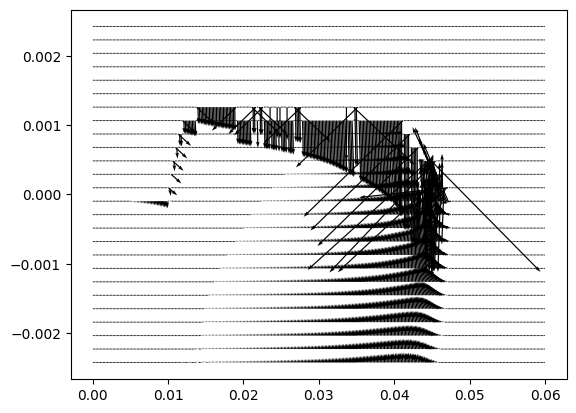

In [24]:
tstep = 20
plt.quiver(MeshX[:,50,:],MeshZ[:,50,:],gradX[tstep,:,50,:],gradZ[tstep,:,50,:])

In [22]:
tstep = 15
# # Vector
# a =  mlab.quiver3d(MeshX,MeshY,MeshZ,u[tstep],v[tstep],w[tstep])
# # Scalar
# a =  mlab.points3d(MeshX,MeshY,MeshZ,u[tstep])
mlab.show()

In [26]:
np.max(R,axis=(1,2,3))

array([0.        , 0.        , 0.00368561, 0.00619591, 0.00744446,
       0.00897526, 0.00851336, 0.01102732, 0.01296811, 0.01492553,
       0.01689221, 0.01827165, 0.01787301, 0.01784087, 0.01612593,
       0.01644619, 0.01853556, 0.01857492, 0.01907195, 0.01813512,
       0.01871075, 0.02197353])

In [29]:
np.max(grad,axis=(1,2,3))

array([4.03274504e-10, 7.58977497e+06, 8.09861301e+06, 8.28476892e+06,
       7.89713232e+06, 7.93961215e+06, 8.02027643e+06, 7.72712656e+06,
       8.07568715e+06, 8.43287480e+06, 8.30737616e+06, 8.19247396e+06,
       8.46112976e+06, 8.07777750e+06, 8.19889085e+06, 8.15573376e+06,
       8.15511775e+06, 8.22993408e+06, 7.79894152e+06, 7.88820604e+06,
       7.88900303e+06, 8.15247850e+06])